#**Машинное обучение ИБ-2024**

#**Домашнее задание 1.**
#Регрессия, KNN, LinearRegression.

В данной домашней работе мы будем строить модели для предсказания цены квартиры в России. Ниже приведено описание некоторых колонок набора данных.

date - дата публикации объявления

price - цена в рублях

level- этаж, на котором находится квартира

levels - количество этажей в квартире

rooms - количество комнат в квартире. Если значение -1, то квартира считается апартаментами.

area - площадь квартиры.

kitchen_area - площадь кухни.

geo_lat - Latitude

geo_lon - Longitude

building_type - материал застройки. 0 - Don't know. 1 - Other. 2 - Panel. 3 - Monolithic. 4 - Brick. 5 - Blocky. 6 - Wooden

#Часть 0. Начало работы

Для начала работы с данными импортируем библиотеки, которые понадобятся в данном задании.

In [1]:
import math
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns

Загрузим библиотеку folium для отображения данных на карте по координатам.

In [2]:
!pip install folium

Распакуем наши данные из архива.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip /content/drive/MyDrive/deze1_lin_knn_modeli.zip

Archive:  /content/drive/MyDrive/deze1_lin_knn_modeli.zip
  inflating: input_data.csv          


Загрузим данные из csv файла в датафрейм.

In [5]:
df = pd.read_csv(
    '/content/input_data.csv',
    sep=';'
)
df.head()

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id
0,2021-01-01,2451300,15,31,1,30.3,0.0,56.780112,60.699355,0,2,620000.0,NaN,66,1632918.0
1,2021-01-01,1450000,5,5,1,33.0,6.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
2,2021-01-01,10700000,4,13,3,85.0,12.0,55.540060,37.725112,3,0,142701.0,242543.0,50,681306.0
3,2021-01-01,3100000,3,5,3,82.0,9.0,44.608154,40.138381,0,0,385000.0,NaN,1,NaN
4,2021-01-01,2500000,2,3,1,30.0,9.0,44.738685,37.713668,3,2,353960.0,439378.0,23,1730985.0


Отобразим на карте координаты наших построек.

In [6]:
import folium
from IPython.display import display

map_df = df.loc[:1000]

m = folium.Map(location=[55.751244, 37.618423], zoom_start=10)

# Список точек с широтой и долготой
lats = map_df['geo_lat'].loc[:1000]
longs = map_df['geo_lon'].loc[:1000]
# Добавляем точки на карту
for point in zip(lats, longs):
    folium.Marker(
        location=[point[0], point[1]]
    ).add_to(m)

display(m)

# Часть 1. Подготовим данные для обработки моделями машинного обучения.

**0.5 Балл**. География наших наблюдений в наборе данных крайне большая. Однако мы знаем, что стоимость квартир в Москве и Санкт-Петербурге намного выше, чем в среднем по России. Давайте сделаем признаки, который показывают, находится ли квартира в 20 килиметрах от центра Москвы или находится ли квартира в 20 килиметрах от центра Санкт-Петербурга.

Создайте два признака is_Moscow и is_Saint_Peterburg. Для нахождения расстояния по координатам используйте функцию haversine_distance.

In [7]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

Moscow = (55.755811, 37.617617)
Piter = (59.938670, 30.314350)

Mos_rad = [radians(x) for x in Moscow]
Pit_rad = [radians(x) for x in Piter]

lats_rad = df['geo_lat'].apply(radians)
lons_rad = df['geo_lon'].apply(radians)

df[['is_Moscow', 'is_Saint_Peterburg']] = haversine_distances(
    np.array([lats_rad, lons_rad]).T,
    [Mos_rad, Pit_rad])*6371 <= 20

**0.5 Балла**. В нашем наборе данных есть признаки, которые мы теоретически можем использовать, например postal_code, но мы это будем делать в рамках домашней работы очень-очень долго. Поэтому предлагается удалить ненужные признаки из датафрейма.

Удалим geo_lat,	geo_lon,	object_type,	postal_code,	street_id,	id_region,	house_id.

In [8]:
bad = 'geo_lat, geo_lon, object_type, postal_code, street_id, id_region, house_id'.split(', ')

for column in bad:
  del df[column]

df.head(5)

,date,price,level,levels,rooms,area,kitchen_area,building_type,is_Moscow,is_Saint_Peterburg
0,2021-01-01,2451300,15,31,1,30.3,0.0,0,False,False
1,2021-01-01,1450000,5,5,1,33.0,6.0,0,False,False
2,2021-01-01,10700000,4,13,3,85.0,12.0,3,False,False
3,2021-01-01,3100000,3,5,3,82.0,9.0,0,False,False
4,2021-01-01,2500000,2,3,1,30.0,9.0,3,False,False


**0.5 Балл**. Для начала Вам предлагается проанализировать Ваши оставшиеся признаки (колонки) в наборе данных. Какие колонки категориальные? Какие числовые?

Категориальные: building_type	is_Moscow	is_Saint_Peterburg

Числовые: date	price	level	levels	rooms	area	kitchen_area

Давайте закодируем категориальные признаки с помощью OneHot-Encoding. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

cat_cols = [
    'building_type',
    'is_Moscow',
    'is_Saint_Peterburg'
]
num_cols = [
    'level',
    'levels',
    'rooms',
    'area',
    'kitchen_area'
]
target = 'price'

new_num_cols = [
    'days_from_first',
    'dolya_level'
]
df['days_from_first'] =  (pd.to_datetime(df['date'])-(pd.to_datetime(df['date']).min())).dt.days
df['dolya_level'] = df['level']/df['levels']
df.sample(5)

,date,price,level,levels,rooms,area,kitchen_area,geo_lat,geo_lon,building_type,object_type,postal_code,street_id,id_region,house_id,is_Moscow,is_Saint_Peterburg,days_from_first,dolya_level
754143,2021-02-06,7900000,2,10,3,102.2,0.0,57.112387,65.590176,4,0,625046.0,373841.0,72,1238982.0,False,False,36,0.200000
8648933,2021-10-06,3835000,4,5,3,60.0,6.9,55.127491,82.895682,0,0,630040.0,579548.0,54,2502159.0,False,False,278,0.800000
9264066,2021-10-25,10700000,4,9,1,31.0,5.0,55.853370,37.640156,0,0,129323.0,220535.0,77,1207291.0,True,False,297,0.444444
6441116,2021-08-02,9000000,3,5,5,154.0,15.3,55.107341,36.617445,0,0,249031.0,328005.0,40,2455297.0,False,False,213,0.600000
481412,2021-01-28,4060000,1,11,2,50.9,16.2,57.155053,65.582773,4,0,625048.0,150601.0,72,2530759.0,False,False,27,0.090909


In [9]:
encoder = ColumnTransformer([
    ('cat', OneHotEncoder(drop = 'first', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols+new_num_cols )
])
df = df.replace([np.inf, -np.inf], np.nan).dropna()
scaller = StandardScaler()
X = encoder.fit_transform(df[cat_cols+num_cols+new_num_cols])
y = scaller.fit_transform(df[target].to_numpy().reshape( df[target].shape[0], -1))

In [10]:
X = pd.DataFrame(X).to_numpy()
y = pd.DataFrame(y).to_numpy()

**0.5 Балл**. Поработаем с числовыми признаками:


1.   Добавьте в ваш датасет два признака: количество дней со дня первого наблюдения (разница между датами объявлений). Возможно, для предсказания цены не так важен этаж, как важно отношение этажа квартиры на количество этажей в доме, добавьте этот признак. После добавления нового признака колонку date можно удалить.
2.   Числовые признаки могут иметь разные порядки. Давайте отнормируем числовые признаки с помощью StandartScaller https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html.



In [ ]:
#сделал выше

**2 Балла**. Реализуйте класс KNNRegressor, который должен делать регрессию методом k ближайших соседей.

In [11]:
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from tqdm.notebook import tqdm

class KNNRegressor:
    def __init__(self, n_neighbors=5, metric='euclidean'):
      self.n = n_neighbors
      self.X = 0
      self.y = 0
      self.metrics = {
          'euclidean': euclidean_distances,
          'cosine' : cosine_distances
      }
      self.metric = self.metrics[metric]
    def fit(self, X, y):
      self.X = X
      self.y = y
    def predict(self, X):
      rasstoyanie = self.metric(self.X , X)
      need = rasstoyanie.argsort(axis=0).T[:,:self.n]
      return self.y[need].mean(axis=1)



**3 Балла**. Реализуйте класс LinearRegression, поддерживающий обучение градиентными спусками SGD, Momentum, AdaGrad. Используйте градиент для оптимизации функции потерь MSE.

In [12]:
from sklearn.utils import shuffle
class LinearRegressor:
    def __init__(self, learning_rate=0.01, optimization='SGD', epsilon=1e-8, decay_rate=0.9, max_iter=1000, epoch=3, batch_size=128):
        self.learning_rate = learning_rate
        self.optimization = optimization
        self.epsilon = epsilon
        self.decay_rate = decay_rate
        self.max_iter = max_iter
        self.weights = None
        self.bias = None
        self.epoch = epoch
        self.batch_size = batch_size

    def gradient(self, X_batch, y_batch):
        y_pred = self.predict(X_batch)
        error = y_pred - y_batch
        gradient_weights = 2*X_batch.T.dot(error) / self.batch_size
        gradient_bias = 2* error.sum() / self.batch_size
        return gradient_weights, gradient_bias

    def fit(self, X, y):
        if self.weights == None:
          self.weights = np.random.randn(X.shape[1])
        if self.bias == None:
          self.bias = np.random.randn()

        if self.optimization == 'Momentum':
          last_gradient_weigts = 0
          last_gradient_bias = 0

        elif self.optimization == 'AdaGrad':
          G_weights = None
          G_bias = None
          G_flag = 1

        step = 0
        for epoch in range(self.epoch):
          X, y = shuffle(X, y, random_state=42)
          for batch in range(self.batch_size, X.shape[0], self.batch_size):
            X_batch = X[batch-self.batch_size:batch]
            y_batch = y[batch-self.batch_size:batch].reshape(-1)
            gradient_weights, gradient_bias = self.gradient(X_batch, y_batch)
            if self.optimization == 'Momentum':
              gradient_weights = last_gradient_weigts * self.decay_rate + gradient_weights * (1 - self.decay_rate)
              gradient_bias = last_gradient_bias * self.decay_rate + gradient_bias * (1 - self.decay_rate)
              last_gradient_weigts = gradient_weights
              last_gradient_bias = gradient_bias

            elif self.optimization == 'AdaGrad':
              if G_flag == 1 :
                G_weights = gradient_weights**2
                G_bias = gradient_bias**2
                G_flag = 0

              G_weights = self.decay_rate * G_weights + gradient_weights**2 * (1 - self.decay_rate)
              G_bias = self.decay_rate * G_bias + gradient_bias**2 * (1 - self.decay_rate)

              gradient_weights =  gradient_weights / np.sqrt(G_weights + self.epsilon)
              gradient_bias = gradient_bias / np.sqrt(G_bias + self.epsilon)


            self.weights -= self.learning_rate*gradient_weights
            self.bias -= self.learning_rate*gradient_bias

            step += 1
            if step%1000 == 0:
              self.learning_rate = self.learning_rate/2
            if step >= self.max_iter:
              return self
        return self

    def predict(self, X):
        return X.dot(self.weights) + self.bias

# Часть 2. Эксперименты с моделями машинного обучения.

**3 Балла**. Проведите эксперименты с написанными Вами методами машинного обучения. Выделите обучающую и тестовую выборки в отношении 0,8 и 0,2 соответственно. Измерьте ошибку MSE, MAE, RMSE. Заиспользуйте методы KNNRegressor и LinearRegression из библиотеки sklearn, сравните качество Ваших решений и библиотечных.

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

def train_predict_KNN(model, batch, num_pos):
  MSE = 0
  MAE = 0
  X_small, y_small = X[:num_pos, :], y[:num_pos, :]
  X_train, X_test, y_train, y_test = train_test_split(
    X_small, y_small, test_size=0.2, random_state= 42, shuffle=True
  )
  model.fit(X_train, y_train)
  if batch != None:
    for B in tqdm(range(batch, X_test.shape[0],batch)):
      X_batch = X_test[B-batch:B]
      y_batch = y_test[B-batch:B]
      pred_batch = model.predict(X_batch)
      MSE += mean_squared_error(y_batch, pred_batch).mean()
      MAE += mean_absolute_error(y_batch, pred_batch).mean()
    MSE = MSE / (X_test.shape[0]//batch)
    MAE = MAE / (X_test.shape[0]//batch)

  else:
    pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, pred).mean()
    MAE = mean_absolute_error(y_test, pred).mean()
  return MSE, MAE

  0%|          | 0/4999 [00:00<?, ?it/s]

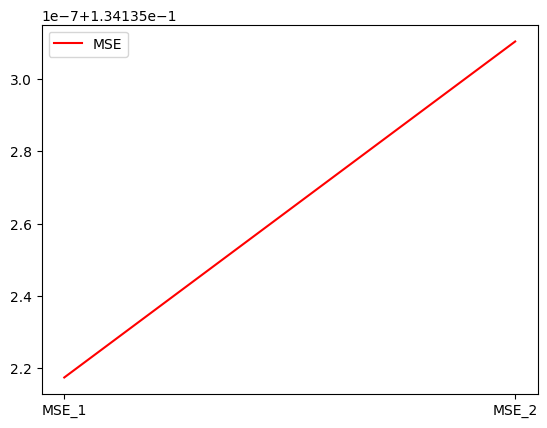

In [14]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

KNN1 = KNNRegressor()
MSE_1, MAE_1 = train_predict_KNN(KNN1, 4, 100000)

KNN2 = KNeighborsRegressor()
MSE_2, MAE_2 = train_predict_KNN(KNN2, None, 100000)

RMSE_1, RMSE_2 = MSE_1 ** 0.5, MSE_2 ** 0.5

MSE_knn = [MSE_1, MSE_2]
metki = ['MSE_1', 'MSE_2']

plt.plot(metki, MSE_knn, color='r', label='MSE')
plt.legend()
plt.show()

In [15]:
MSE_1, MSE_2

(0.13413521738540388, 0.1341353104426918)

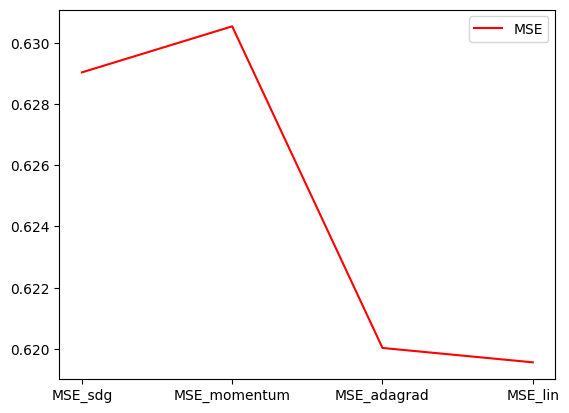

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state= 42, shuffle=True
)
#Создаем модели
############################################################
LinReg_sgd = LinearRegressor(max_iter=10*1000)
LinReg_moment = LinearRegressor(optimization='Momentum', max_iter=10*1000)
LinReg_adagrad = LinearRegressor(optimization='AdaGrad', max_iter=10*1000)

LinReg = LinearRegression()

#Обучаем модели
############################################################
LinReg_sgd.fit(X_train, y_train)
LinReg_moment.fit(X_train, y_train)
LinReg_adagrad.fit(X_train, y_train)

LinReg.fit(X_train, y_train)

#Предсказываем на тестовой выборке
############################################################
pred_sdg = LinReg_sgd.predict(X_test)
pred_moment = LinReg_moment.predict(X_test)
pred_adagrad = LinReg_adagrad.predict(X_test)

pred_lin = LinReg.predict(X_test)

#Считаем метрики
############################################################
MSE_sgd = mean_squared_error(y_test, pred_sdg)
MAE_sgd = mean_absolute_error(y_test, pred_sdg)
RMSE_sgd = MSE_sgd**0.5

MSE_moment = mean_squared_error(y_test, pred_moment)
MAE_moment = mean_absolute_error(y_test, pred_moment)
RMSE_moment = MSE_moment**0.5

MSE_adagrad = mean_squared_error(y_test, pred_adagrad)
MAE_adagrad = mean_absolute_error(y_test, pred_adagrad)
RMSE_adagrad = MSE_adagrad**0.5

MSE_lin = mean_squared_error(y_test, pred_lin)
MAE_lin = mean_absolute_error(y_test, pred_lin)
RMSE_lin = MSE_lin**0.5

#Отрисуем значения метрик ошибок
############################################################
res = [MSE_sgd, MSE_moment, MSE_adagrad, MSE_lin]

metki = ['MSE_sdg', 'MSE_momentum', 'MSE_adagrad', 'MSE_lin']
############################################################
plt.plot(metki, res, color='r', label='MSE')
plt.legend()
plt.show()

In [19]:
pd.DataFrame({
    'SGD': [MSE_sgd, MAE_sgd, RMSE_sgd],
    'Momentum' : [MSE_moment, MAE_moment, RMSE_moment],
    'AdaGrad' : [MSE_adagrad, MAE_adagrad, RMSE_adagrad],
    'Sklearn': [MSE_lin, MAE_lin, RMSE_lin]
})
#1 строка MSE, 2 - MAE, 3 - RMSE

,SGD,Momentum,AdaGrad,Sklearn
0,0.629029,0.630532,0.620032,0.619562
1,0.092544,0.088899,0.066744,0.072751
2,0.793113,0.794060,0.787421,0.787123
